# Model topology 01: introduction to model topology with `gempy`

By Florian Wellmann, Sofia Brisson, and Nils Chudalla

Small intro to model topology - on the basis of the simple faulted layer example. We explore here the different ways that we can visualize topology.

In [1]:
import gempy as gp
from gempy.assets import topology as tp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import norm

import warnings
warnings.filterwarnings("ignore")

No module named 'osgeo'


## Initial gempy model

First we create a very simple, 2 layer model with a normal fault using Gempy.

In [2]:
geo_model = gp.create_model('topology_example')
geo_model = gp.init_data(geo_model, extent = [0, 1000, 0, 1000, 0, 1000], resolution = [30,30,30],
                        path_o = 'or_prior_simpler.csv',
                        path_i = 'surf_prior_simpler.csv')

gp.map_stack_to_surfaces(geo_model, 
                        {'fault' : ['fault'],
                        'layers' : ['rock1', 'rock2']})

geo_model.set_is_fault(['fault'])

geo_model.surfaces.colors.change_colors({'rock1': '#a1d99b',
                                        'rock2' : '#3182bd',
                                        'basement' : '#d9d9d9'})


interp_data = gp.set_interpolator(geo_model,
                                 compile_theano=True,
                                 theano_optimizer='fast_run', gradient=False,
                                 dype='float32')
gp.compute_model(geo_model)

#gp.plot_3d(geo_model)

Active grids: ['regular']
Fault colors changed. If you do not like this behavior, set change_color to False.
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  1
Compilation Done!
Kriging values: 
                     values
range              1732.05
$C_o$              71428.6
drift equations  [3, 3, 3]



Lithology ids 
  [4. 4. 4. ... 2. 2. 2.] 

### Topology of initial model

The topology network graph can be visualized "manually"in 3D:

In [3]:
edges, centroids = tp.compute_topology(geo_model)

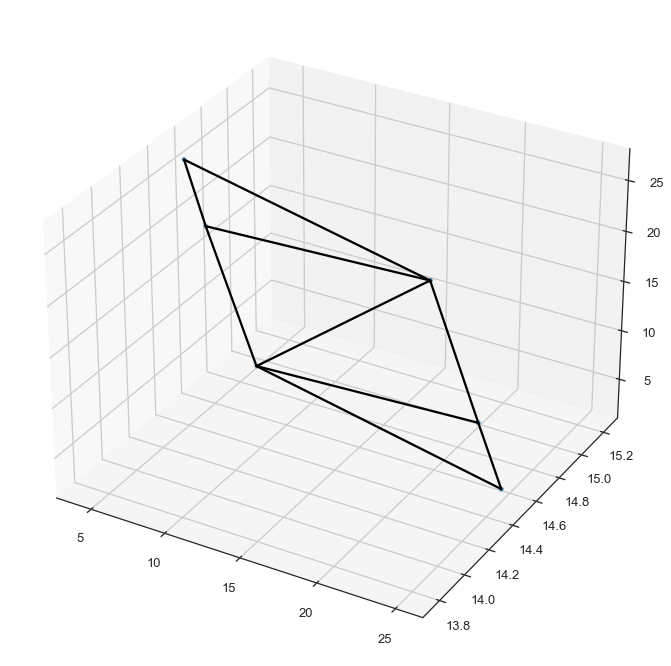

In [4]:
node_indices = []
x,y,z = [],[],[]
for key,coordinates in centroids.items():
    x.append(coordinates[0])
    y.append(coordinates[1])
    z.append(coordinates[2])
    node_indices.append(key)
    
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(projection='3d')
ax.scatter(x,y,z)


for k in edges:
    first_node = k[0]
    second_node = k[1]
    i_1 = node_indices.index(first_node)
    i_2 = node_indices.index(second_node)
    ax.plot([x[i_1],x[i_2] ] , [y[i_1],y[i_2]], [z[i_1], z[i_2]], color="black")

Or the topology of the initial model can directly be generated with methods from the `gempy.assets` module `topology` (see import above: `from gempy.assets import topology as tp`):

A plot of the topology network is also directly possible:

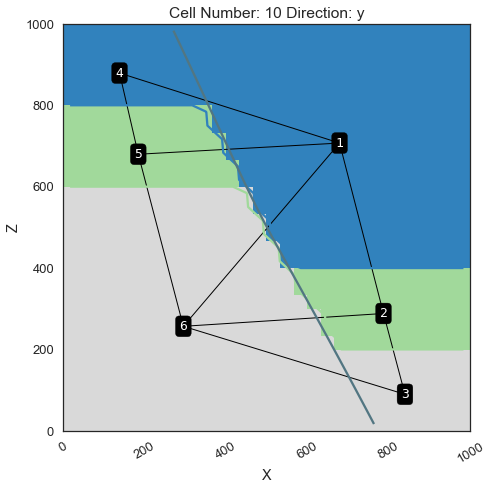

In [5]:
gp.plot_2d(geo_model, show_data = False, direction = 'y', cell_number = 10)
gp.plot.plot_topology(geo_model, edges, centroids, scale=True)
plt.show()

Another (dual) representation of the topology is the representation in an adjacency matrix. This matrix can be calculated with:

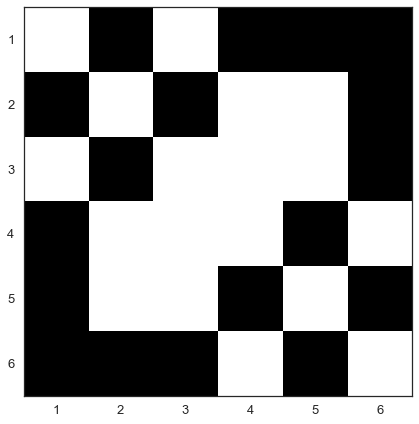

In [6]:
adj_matrix_1 = tp.get_adjacency_matrix(geo_model, edges, centroids).astype(np.int8)

fig, ax = plt.subplots(1,1)
ax.imshow(adj_matrix_1)
ax.set_xticks(np.arange(6))
ax.set_xticklabels(np.arange(1,7))
ax.set_yticks(np.arange(6))
ax.set_yticklabels(np.arange(1,7));

This matrix shows the same information as the graph network above. For example, volume 2 is connected to 1, 3 and 6.

### Fancier adjacency matrix (by Nils Chudalla)

We can also try and color in the matrix squares according to whether the relationships are stratigraphic or structural. Also, we can try and separate the fault blocks.

In [8]:
# Build fancy adjancy matrix

lith_ids = tp.get_lith_ids(geo_model)
liths = len(lith_ids)
fault_ids = tp.get_fault_ids(geo_model)
faults = len(fault_ids)

strat_matr = np.ones((faults*liths,faults*liths), dtype=int)

adj_matrix = tp.get_adjacency_matrix(geo_model, edges, centroids).astype(np.int)
for i in range(faults):
    strat_matr[i*(faults+1):i*(faults+1)+liths, i*(faults+1):i*(faults+1)+liths] = 2

final_adj_matrix = strat_matr * adj_matrix

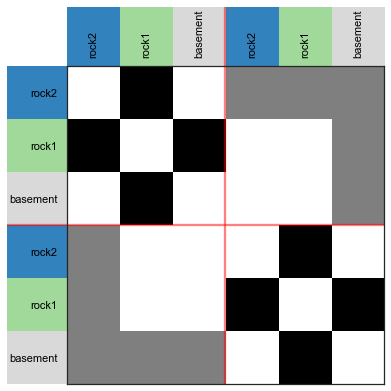

<Figure size 748.8x514.8 with 0 Axes>

In [9]:
import matplotlib.colors as mcolors

### Define styling of figure
fig_size = 14                               # figuresize in cm
plot_lith_names = True                      # Turn True/False to either plot names of liths or only their IDs
plot_fault_segments = True                 # Turn True/False to highlight the different segments of faults
fault_seg_color = 'red'                     # Color of segmentation line
cmap = 'tab20c'
#cmap = mcolors.ListedColormap(
#    list(geo_model._surfaces.df['color']))  # Automatic extraction of colors of geomodel

# check out https://matplotlib.org/stable/tutorials/text/text_props.html for more options to make labels nice

tick_labels = {
    'family': 'arial',
    'color':  'black',
    #'weight': 'bold',
    'size': 11,
    }

### Build axes
fig = plt.figure(figsize=(fig_size/2.54,fig_size/2.54))
y0 = 0.0    # padding value for rel. distance to bottom
x0 = 0.0    # padding value for rel. distance to left
strati_width = 0.15     # scaling value for rel. thickness of colored bars
box_height = 0.8    # scaling value for rel. width/height of matrix

vert_ax = fig.add_axes([x0, y0, strati_width, box_height]) # build vertical axes
hori_ax = fig.add_axes([x0+strati_width, y0+box_height, box_height, strati_width]) # build horizontal axes
box_ax = fig.add_axes([x0+strati_width, y0,box_height, box_height]) # build matrix axes

### Build stack of repeating liths to fill axis
stratid_stack = np.array([])

for i in range(faults):
    stratid_stack = np.hstack([stratid_stack, lith_ids])

### Build string list with lith names
df = geo_model.surfaces.df.set_index('id')
strat_stack = df['surface'].loc[stratid_stack].values

# plot colorbars and matrix
hori_ax.imshow(stratid_stack.reshape(1,-1), origin='upper', aspect='auto', cmap=cmap)
vert_ax.imshow(stratid_stack.reshape(-1,1), origin='upper', aspect='auto', cmap=cmap)

box_ax.imshow(final_adj_matrix, cmap='gray_r')
box_ax.xaxis.tick_top()

# Style axis
xticks = box_ax.get_xticklabels()
yticks = box_ax.get_yticklabels()

vert_ax.axis('off')
hori_ax.axis('off')
if plot_lith_names == True:
    xticks[1:] = strat_stack
    box_ax.set_xticklabels(xticks, minor=False, rotation=90, fontdict=tick_labels)
    yticks[1:] = strat_stack
    box_ax.set_yticklabels(yticks, minor=False, fontdict=tick_labels)
else:
    xticks[1:] = stratid_stack.astype(int)
    box_ax.set_xticklabels(xticks, minor=False, fontdict=tick_labels)
    yticks[1:] = stratid_stack.astype(int)
    box_ax.set_yticklabels(yticks, minor=False, fontdict=tick_labels)

# Plot fault segments if wanted
if plot_fault_segments == True:
    pos = (len(stratid_stack) - 1) / 2 # length of fault ids
    for i in range(1,faults):
        box_ax.hlines(pos*i, -0.5, len(stratid_stack)-0.5, color=fault_seg_color, alpha = 0.5)
        box_ax.vlines(pos*i, -0.5, len(stratid_stack)-0.5, color=fault_seg_color, alpha = 0.5)
        vert_ax.hlines(pos*i, -0.5, 0.5, color=fault_seg_color, alpha = 0.5)
        hori_ax.vlines(pos*i, -0.5, 0.5, color=fault_seg_color, alpha = 0.5)
plt.show()
plt.savefig('ad_matrix.svg')